这个笔记本用于比较低维模拟数据下不同方法的拟合效果。

In [1]:
import os
from os.path import join, dirname, exists
import matplotlib.pyplot as plt
import numpy as np
import pickle
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.utils import make_grid
import warnings
warnings.filterwarnings('ignore')
import torch.optim as optim
from scipy.stats import norm
from tqdm import trange, tqdm_notebook
from torch.distributions.uniform import Uniform
from torch.distributions.normal import Normal
import collections
from scipy.stats import rv_discrete

def savefig(fname, show_figure=True):
    if not exists(dirname(fname)):
        os.makedirs(dirname(fname))
    plt.tight_layout()
    plt.savefig(fname)
    if show_figure:
        plt.show()


def save_training_plot(train_losses, test_losses, title, fname):
    plt.figure()
    n_epochs = len(test_losses) - 1
    x_train = np.linspace(0, n_epochs, len(train_losses))
    x_test = np.arange(n_epochs + 1)

    plt.plot(x_train, train_losses, label='train loss')
    plt.plot(x_test, test_losses, label='test loss')
    plt.legend()
    plt.title(title)
    plt.xlabel('Epoch')
    plt.ylabel('NLL')
    savefig(fname)

In [8]:
def sample_data(count, ind):
    if ind == 1:
        MEANS = np.array([[0.3, 0.2], [1, 1.2]])
        COVS = np.array([[[0.7, 0.3], [0.3, 0.2]],
                         [[0.7, -0.3], [-0.3, 0.2]]])
        PROBS = np.array([0.5, 0.5])
        assert len(MEANS) == len(COVS) == len(
            PROBS), "number of components mismatch"
        COMPONENTS = len(MEANS)

        comps_dist = rv_discrete(values=(range(COMPONENTS), PROBS))
        comps = comps_dist.rvs(size=count)
        conds = np.arange(COMPONENTS)[:, None] == comps[None, :]
        arr = np.array([np.random.multivariate_normal(MEANS[c], COVS[c], size=count)
                        for c in range(COMPONENTS)])
        return np.select(conds[:, :, None], arr).astype(np.float32)
    
    if ind == 2:
        rand = np.random.RandomState(0)
        def get_samples(c, size):
            if c==0:
                return np.random.multivariate_normal([-1.5, 2.5], [[0.2, 0], [0, 0.2]], size=count)
            if c==1:
                return np.random.multivariate_normal([1.5, 2.5], [[0.2, 0], [0, 0.2]], size=count)
            if c==2:
                noise = rand.rand(count)
                samples = np.c_[2 * np.cos(np.pi * noise), -2 * np.sin(np.pi * noise)]
                samples += rand.randn(*samples.shape) * 0.2
                return samples
        PROBS = np.array([1/3, 1/3, 1/3])
        COMPONENTS = 3
        comps_dist = rv_discrete(values=(range(COMPONENTS), PROBS))
        comps = comps_dist.rvs(size=count)
        conds = np.arange(COMPONENTS)[:, None] == comps[None, :]
        arr = np.array([get_samples(c, count) for c in range(COMPONENTS)])
        return np.select(conds[:, :, None], arr).astype(np.float32)
    
def get_data(count, ind):
    train_data, test_data = sample_data(count, ind), sample_data(count//2, ind)
    return train_data.astype('float32'), test_data.astype('float32')

def visualize_dataset(ind):
    data = sample_data(10000, ind)
    plt.hist2d(data[:, 0], data[:, 1], bins=(300, 300), alpha=0.7, cmap=plt.cm.jet, label="train data")
    plt.legend()
    plt.colorbar()
    plt.show()

No handles with labels found to put in legend.


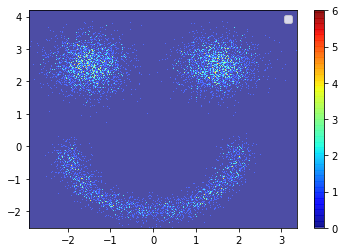

In [9]:
visualize_dataset(2)

In [10]:
# GPU Wrapper to make a better world
_use_gpu = True
DEVICE = None
_gpu_id = 0

def set_gpu_mode(mode, gpu_id=0):
    global _use_gpu
    global DEVICE
    global _gpu_id
    _gpu_id = gpu_id
    _use_gpu = mode
    DEVICE = torch.device("cuda:" + str(gpu_id) if _use_gpu else "cpu")

def FloatTensor(*args, torch_device=None, **kwargs):
    if torch_device is None:
        torch_device = DEVICE
    return torch.FloatTensor(*args, **kwargs).to(torch_device)

def get_numpy(tensor):
    return tensor.to('cpu').detach().numpy()

def zeros(*sizes, torch_device=None, **kwargs):
    if torch_device is None:
        torch_device = DEVICE
    return torch.zeros(*sizes, **kwargs, device=torch_device)


def ones(*sizes, torch_device=None, **kwargs):
    if torch_device is None:
        torch_device = DEVICE
    return torch.ones(*sizes, **kwargs, device=torch_device)


def ones_like(*args, torch_device=None, **kwargs):
    if torch_device is None:
        torch_device = DEVICE
    return torch.ones_like(*args, **kwargs, device=torch_device)

def zeros_like(*args, torch_device=None, **kwargs):
    if torch_device is None:
        torch_device = DEVICE
    return torch.zeros_like(*args, **kwargs, device=torch_device)


def tensor(*args, torch_device=None, **kwargs):
    if torch_device is None:
        torch_device = DEVICE
    return torch.tensor(*args, **kwargs, device=torch_device)

def normal(*args, **kwargs):
    return torch.normal(*args, **kwargs).to(DEVICE)

set_gpu_mode(False)

记录VAE训练过程及结果的函数

In [31]:
class MLP(nn.Module):
    def __init__(self, input_size, n_hidden, hidden_size, output_size):
        super().__init__()
        layers = []
        for _ in range(n_hidden):
            layers.append(nn.Linear(input_size, hidden_size))
            layers.append(nn.LeakyReLU(0.2))
            input_size = hidden_size
        layers.append(nn.Linear(hidden_size, output_size))
        self.layers = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.layers(x)

class MLPVAE(nn.Module):
    def __init__(self, input_dim, latent_dim, enc_hidden_size, n_enc_hidden,
                 dec_hidden_size, n_dec_hidden):
        super().__init__()
        self.latent_dim = latent_dim
        self.encoder = MLP(input_dim, n_enc_hidden, enc_hidden_size, 2 * latent_dim)
        self.decoder = MLP(latent_dim, n_dec_hidden, dec_hidden_size, 2 * input_dim)
    
    def loss(self, x):
        mu_z, log_std_z = self.encoder(x).chunk(2, dim=1)
        z = torch.randn_like(mu_z) * log_std_z.exp() + mu_z
        mu_x, log_std_x = self.decoder(z).chunk(2, dim=1)

        recon_loss = 0.5 * np.log(2 * np.pi) + log_std_x + \
                     (x - mu_x) ** 2 * torch.exp(-2 * log_std_x) * 0.5
        recon_loss = recon_loss.mean()

        kl_loss = -log_std_z - 0.5 + (torch.exp(2 * log_std_z) + mu_z ** 2) * 0.5
        kl_loss = kl_loss.mean()

        return dict(loss=recon_loss+kl_loss, recon_loss=recon_loss, kl_loss=kl_loss)
    
    def sample(self, n, noise=True):
        with torch.no_grad():
            z = torch.randn(n, self.latent_dim).cuda()
            mu, log_std = self.decoder(z).chunk(2, dim=1)
            if noise:
                z = torch.randn_like(mu) * log_std.exp() + mu
            else:
                z = mu
        return z.cpu().numpy()
    
def plot_vae_training(train_losses, test_losses, title, fname):
    elbo_train, recon_train, kl_train = train_losses[:, 0], train_losses[:, 1], train_losses[:, 2]
    elbo_test, recon_test, kl_test = test_losses[:, 0], test_losses[:, 1], test_losses[:, 2]
    plt.figure()
    n_epochs = len(test_losses) - 1
    x_train = np.linspace(0, n_epochs, len(train_losses))
    x_test = np.arange(n_epochs + 1)

    plt.plot(x_train, elbo_train, label='-elbo_train')
    plt.plot(x_train, recon_train, label='recon_loss_train')
    plt.plot(x_train, kl_train, label='kl_loss_train')
    plt.plot(x_test, elbo_test, label='-elbo_test')
    plt.plot(x_test, recon_test, label='recon_loss_test')
    plt.plot(x_test, kl_test, label='kl_loss_test')
    
    plt.legend()
    plt.title(title)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    savefig(fname)

def vae_save_results(fn, count, ind):
    train_data, test_data = get_data(count, ind)
    train_losses, test_losses, samples_noise, samples_nonoise = fn(train_data, test_data)
    print(f'Final -ELBO: {test_losses[-1, 0]:.4f}, Recon Loss: {test_losses[-1, 1]:.4f}, '
          f'KL Loss: {test_losses[-1, 2]:.4f}')

    plot_vae_training(train_losses, test_losses, 'VAE Train Plot', 'results/vae_train_plot.png')
    vae_plot(test_data, samples_noise, 'w/ Noise/Test', 'results/vae_samples_with_noise_test.png')
    vae_plot(test_data, samples_nonoise, 'w/o Noise/Test', 'results/vae_samples_without_noise_test.png')
    vae_plot(train_data, samples_noise, 'w/ Noise/Train', 'results/vae_samples_with_noise_train.png')
    vae_plot(train_data, samples_nonoise, 'w/o Noise/Train', 'results/vae_samples_without_noise_train.png')

def vae_plot(data, samples, title, fname):
    plt.subplot(121)
    plt.hist2d(samples[:, 0], samples[:, 1], bins=(300, 300), alpha=0.7, label="fitted")
    plt.colorbar()
    plt.title(f'Fitted {title}')
    plt.subplot(122)
    plt.hist2d(data[:, 0], data[:, 1], bins=(300, 300), alpha=0.7, label="data")
    plt.colorbar()
    plt.title(f'Data {title}')
    plt.tight_layout()
    plt.show()
    savefig(fname)

In [13]:
def vae_train(model, train_loader, optimizer, epoch, grad_clip=None):
    model.train()
    
    losses = dict()
    for x in train_loader:
        x = x.cuda()
        out = model.loss(x)
        optimizer.zero_grad()
        out['loss'].backward()
        if grad_clip:
            torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clip)
        optimizer.step()

        for k, v in out.items():
            if k not in losses:
                losses[k] = []
            losses[k].append(v.item())
            avg_loss = np.mean(losses[k][-50:])
    return losses

def vae_eval_loss(model, data_loader):
    model.eval()
    total_losses = dict()
    with torch.no_grad():
        for x in data_loader:
            x = x.cuda()
            out = model.loss(x)
            for k, v in out.items():
                total_losses[k] = total_losses.get(k, 0) + v.item() * x.shape[0]

        for k in total_losses.keys():
            total_losses[k] /= len(data_loader.dataset)

    return total_losses


def vae_train_epochs(model, train_loader, test_loader, train_args):
    epochs, lr = train_args['epochs'], train_args['lr']
    grad_clip = train_args.get('grad_clip', None)
    optimizer = optim.Adam(model.parameters(), lr=lr)

    train_losses, test_losses = dict(), dict()
    for epoch in tqdm_notebook(range(epochs), desc='Epoch', leave=False):
        model.train()
        train_loss = vae_train(model, train_loader, optimizer, epoch, grad_clip)
        test_loss = vae_eval_loss(model, test_loader)

        for k in train_loss.keys():
            if k not in train_losses:
                train_losses[k] = []
                test_losses[k] = []
            train_losses[k].extend(train_loss[k])
            test_losses[k].append(test_loss[k])
    return train_losses, test_losses

In [39]:
def vae_fn(train_data, test_data):
    model = MLPVAE(2, 2, 256, 3, 256, 3).cuda()
    train_loader = torch.utils.data.DataLoader(train_data, batch_size=128, shuffle=True)
    test_loader = torch.utils.data.DataLoader(test_data, batch_size=128)
    train_losses, test_losses = vae_train_epochs(model, train_loader, test_loader,
                                             dict(epochs=100, lr=1e-3))
    train_losses = np.stack((train_losses['loss'], train_losses['recon_loss'], train_losses['kl_loss']), axis=1)
    test_losses = np.stack((test_losses['loss'], test_losses['recon_loss'], test_losses['kl_loss']), axis=1)

    samples_noise = model.sample(5000, noise=True)
    samples_nonoise = model.sample(5000, noise=False)

    return train_losses, test_losses, samples_noise, samples_nonoise

Final -ELBO: 1.0234, Recon Loss: 0.6530, KL Loss: 0.3704


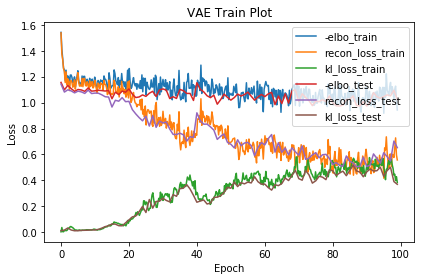

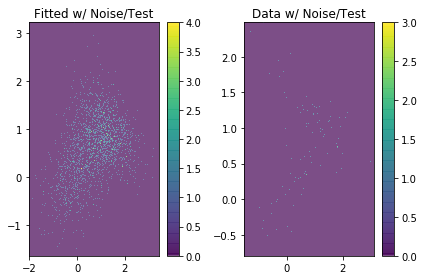

<Figure size 432x288 with 0 Axes>

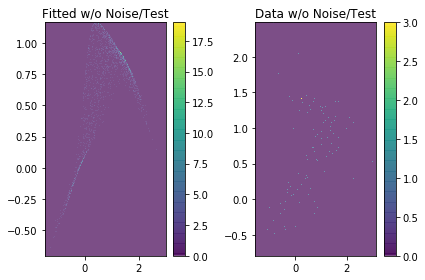

<Figure size 432x288 with 0 Axes>

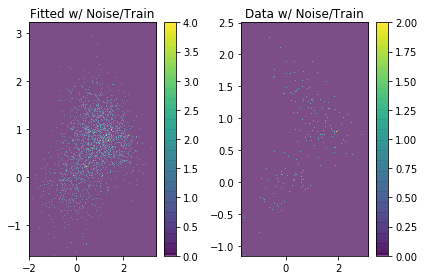

<Figure size 432x288 with 0 Axes>

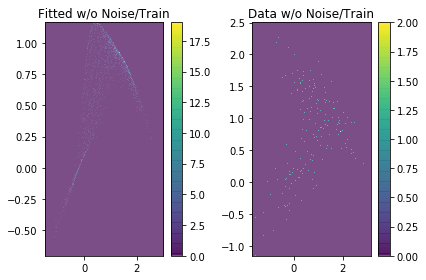

<Figure size 432x288 with 0 Axes>

In [40]:
vae_save_results(vae_fn, 500, ind=1)

Final -ELBO: 1.7835, Recon Loss: 1.2833, KL Loss: 0.5002


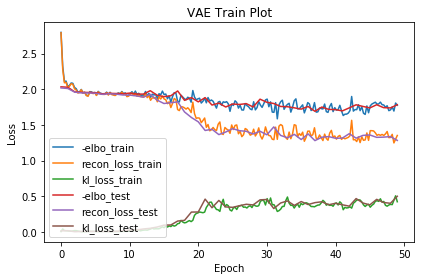

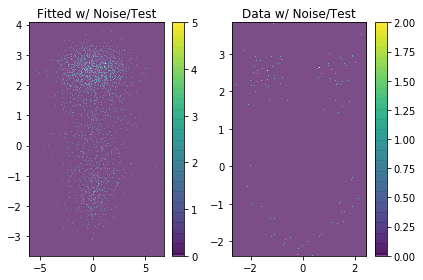

<Figure size 432x288 with 0 Axes>

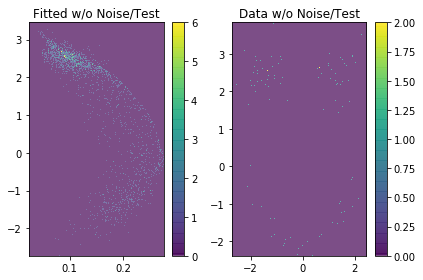

<Figure size 432x288 with 0 Axes>

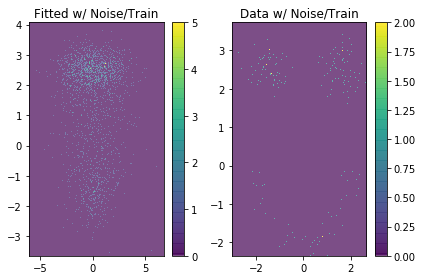

<Figure size 432x288 with 0 Axes>

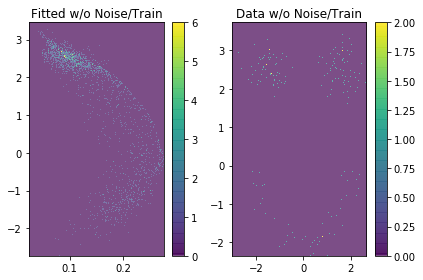

<Figure size 432x288 with 0 Axes>

In [33]:
vae_save_results(vae_fn, 500, ind=2)

Flow Model

In [41]:
class AffineTransform(nn.Module):
    def __init__(self, type, n_hidden=2, hidden_size=256):
        super().__init__()
        self.mask = self.build_mask(type=type)
        self.scale = nn.Parameter(torch.zeros(1), requires_grad=True)
        self.scale_shift = nn.Parameter(torch.zeros(1), requires_grad=True)
        self.mlp = MLP(input_size=2, n_hidden=n_hidden, hidden_size=hidden_size, output_size=2)

    def build_mask(self, type):
        assert type in {"left", "right"}
        if type == "left":
            mask = FloatTensor([1.0, 0.0])
        elif type == "right":
            mask = FloatTensor([0.0, 1.0])
        else:
            raise NotImplementedError
        return mask

    def forward(self, x, reverse=False):
        batch_size = x.shape[0]
        mask = self.mask.repeat(batch_size, 1)
        x_ = x * mask

        g_scale, g_shift = self.mlp(x_).split(1, dim=1)
        log_scale = self.scale * torch.tanh(g_scale) + self.scale_shift
        g_shift = g_shift * (1.0 - mask)
        log_scale = log_scale * (1.0 - mask)
        
        if reverse:
            x = (x - g_shift) * torch.exp(-log_scale)
        else:
            x = x * torch.exp(log_scale) + g_shift
        return x, log_scale

class SigmoidFlow(nn.Module):
    def forward(self, x, reverse=False):
        if reverse:
            z = -torch.log(torch.reciprocal(x) - 1)
        else:
            z = torch.sigmoid(x)
        return z, z.log() + (1-z).log()

class RealNVP(nn.Module):
    def __init__(self, transforms):
        super().__init__()
        self.prior = torch.distributions.Normal(torch.tensor(0.).to(DEVICE), torch.tensor(1.).to(DEVICE))
        self.transforms = nn.ModuleList(transforms)
    
    def flow(self, x):
        z, log_det = x, torch.zeros_like(x)
        for op in self.transforms:
            z, delta_log_det = op.forward(z)
            log_det += delta_log_det
        return z, log_det

    def invert_flow(self, z):
        for op in reversed(self.transforms):
            z, _ = op.forward(z, reverse=True)
        return z
    
    def log_prob(self, x):
        z, log_det = self.flow(x)
        return torch.sum(log_det, dim=1) + torch.sum(self.prior.log_prob(z), dim=1)
    
    def sample(self, num_samples):
        z = self.prior.sample([num_samples, 2])
        return self.invert_flow(z).detach().cpu().numpy()
    
    def nll(self, x):
        return - self.log_prob(x).mean()

In [42]:
def flow_train(model, train_loader, optimizer):
    model.train()
    losses = []
    for x in train_loader:
        x = x.to(DEVICE).float().contiguous()
        loss = model.nll(x)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
    return losses 

def flow_eval_loss(model, data_loader):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for x in data_loader:
            x = x.to(DEVICE).float().contiguous()
            loss = model.nll(x)
            total_loss += loss * x.shape[0]
        avg_loss = total_loss / len(data_loader.dataset)
    return avg_loss.item()

def flow_train_epochs(model, train_loader, test_loader, train_args):
    epochs, lr = train_args['epochs'], train_args['lr']
    optimizer = optim.Adam(model.parameters(), lr=lr)

    train_losses, test_losses = [], []
    test_loss = flow_eval_loss(model, test_loader)
    test_losses.append(test_loss)  # loss at init
    for epoch in tqdm_notebook(range(epochs), desc='Epoch', leave=False):
        model.train()
        epoch_train_losses = flow_train(model, train_loader, optimizer) 
        train_losses.extend(epoch_train_losses)

        test_loss = flow_eval_loss(model, test_loader)
        test_losses.append(test_loss)
            
    return train_losses, test_losses

In [60]:
def flow_fn(train_data, test_data):
    loader_args = dict(batch_size=128, shuffle=True)
    train_loader = torch.utils.data.DataLoader(train_data, **loader_args)
    test_loader = torch.utils.data.DataLoader(test_data, **loader_args)

    real_nvp = RealNVP([AffineTransform("left", n_hidden=2, hidden_size=64),
                        AffineTransform("right", n_hidden=2, hidden_size=64),
                        AffineTransform("left", n_hidden=2, hidden_size=64),
                        AffineTransform("right", n_hidden=2, hidden_size=64),
                        AffineTransform("left", n_hidden=2, hidden_size=64),
                        AffineTransform("right", n_hidden=2, hidden_size=64)])

    train_losses, test_losses = flow_train_epochs(real_nvp, train_loader, test_loader, dict(epochs=50, lr=5e-3))

    dx, dy = 0.025, 0.025
    x_lim = (-1, 1)
    y_lim = (-1, 1)
    y, x = np.mgrid[slice(y_lim[0], y_lim[1] + dy, dy),
                    slice(x_lim[0], x_lim[1] + dx, dx)]
    mesh_xs = FloatTensor(np.stack([x, y], axis=2).reshape(-1, 2))
    densities = np.exp(get_numpy(real_nvp.log_prob(mesh_xs)))

    # latents
    z, _ = real_nvp.flow(FloatTensor(train_data))
    latents = get_numpy(z)

    samples = real_nvp.sample(5000)

    return train_losses, test_losses, densities, latents, samples

In [61]:
def flow_plot(data, samples, title, fname):
    plt.subplot(121)
    plt.hist2d(samples[:, 0], samples[:, 1], bins=(300, 300), alpha=0.7, label="fitted")
    plt.colorbar()
    plt.title(f'Fitted {title}')
    plt.subplot(122)
    plt.hist2d(data[:, 0], data[:, 1], bins=(300, 300), alpha=0.7, label="data")
    plt.colorbar()
    plt.title(f'Data {title}')
    plt.show()
    savefig(fname)

def flow_save_results(fn, count, ind):
    train_data, test_data = get_data(count, ind)
    train_losses, test_losses, densities, latens, samples = fn(train_data, test_data)
    print(f'Final Test Loss: {test_losses[-1]:.4f}')
    save_training_plot(train_losses, test_losses, 'Flow Train Plot',
                       'results/flow_train_plot.png')
    flow_plot(test_data, samples, 'Samples/Test', 'results/flow_samples_test.png')
    flow_plot(train_data, samples, 'Samples/Train', 'results/flow_samples_train.png')

Final Test Loss: 1.8680


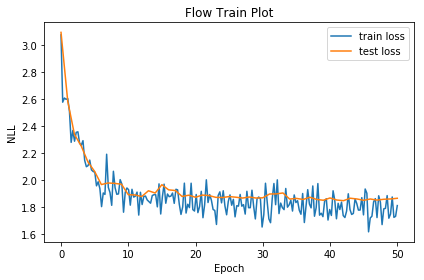

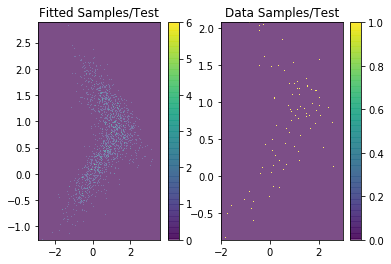

<Figure size 432x288 with 0 Axes>

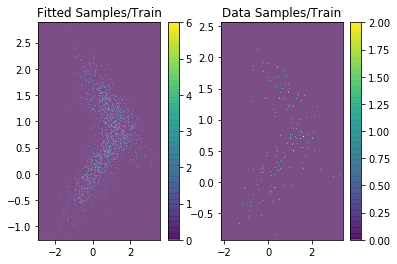

<Figure size 432x288 with 0 Axes>

In [62]:
flow_save_results(flow_fn, 500, ind=1)

In [0]:
def plot_gan_training(losses, title, fname):
    plt.figure()
    n_itr = len(losses)
    xs = np.arange(n_itr)

    plt.plot(xs, losses, label='loss')
    plt.legend()
    plt.title(title)
    plt.xlabel('Training Iteration')
    plt.ylabel('Loss')
    savefig(fname)

def gan_save_results(fn, count):
    data, _ = get_data(count)
    losses, samples1, xs1, ys1, samples_end, xs_end, ys_end = fn(data)
    
    # loss plot
    plot_gan_training(losses, 'GAN Losses', 'results/gan_losses.png')

    # samples
    gan_plot(data, samples1, xs1, ys1, 'GAN Epoch 1', 'results/gan_epoch1.png')
    gan_plot(data, samples_end, xs_end, ys_end, 'GAN Final', 'results/gan_final.png')

def gan_plot(data, samples, xs, ys, title, fname):
    plt.subplot(121)
    plt.hist2d(samples[:, 0], samples[:, 1], bins=(300, 300), alpha=0.7, density=True, cmap=plt.cm.jet, label="fitted", range=[[0,1],[0,1]])
    plt.colorbar()
    plt.title(f'Fitted {title}')
    plt.subplot(122)
    plt.hist2d(data[:, 0], data[:, 1], bins=(300, 300), alpha=0.7, density=True, cmap=plt.cm.jet, label="data", range=[[0,1],[0,1]])
    plt.colorbar()
    plt.title(f'Data {title}')
    plt.tight_layout()
    plt.show()
    savefig(fname)

class MLPGenerator(nn.Module):
    def __init__(self, latent_dim, n_hidden, hidden_size, data_dim):
        super().__init__()
        layers = []
        self.latent_dim = latent_dim
        self.mlp = MLP(latent_dim, n_hidden, hidden_size, data_dim)
    
    def forward(self, z):
        return torch.tanh(self.mlp(z)) 
        return self.mlp(z)
        
    def sample(self, n):
        # n is the number of samples to return
        z = normal(zeros(n, self.latent_dim), ones(n, self.latent_dim))
        return self.forward(z)

class MLPDiscriminator(nn.Module):
    def __init__(self, data_dim, n_hidden, hidden_size):
        super().__init__()
        self.mlp = MLP(data_dim, n_hidden, hidden_size, 1)
    
    def forward(self, x):
        return torch.sigmoid(self.mlp(x))

def gan_train(generator, critic, c_loss_fn, g_loss_fn, train_loader, g_optimizer, c_optimizer, 
          n_critic=1, g_scheduler=None, c_scheduler=None, weight_clipping=None):
    
    g_losses, c_losses = [], []
    generator.train()
    critic.train()
    for i, x in enumerate(train_loader):
        x = x.to(DEVICE).float()
        c_loss = c_loss_fn(generator, critic, x)
        c_optimizer.zero_grad()
        c_loss.backward()
        c_optimizer.step()
        c_losses.append(c_loss.item())
        if weight_clipping is not None:
            for param in critic.parameters():
                param.data.clamp_(-weight_clipping, weight_clipping)

        if i % n_critic == 0:  # generator step
            g_loss = g_loss_fn(generator, critic, x)
            g_optimizer.zero_grad()
            g_loss.backward()
            g_optimizer.step()
            g_losses.append(g_loss.item())
            if g_scheduler is not None:
                g_scheduler.step()
            if c_scheduler is not None:
                c_scheduler.step()
    return dict(g_losses=g_losses, c_losses=c_losses)

def gan_train_epochs(generator, critic, g_loss_fn, c_loss_fn, train_loader, train_args):
    epochs, lr = train_args['epochs'], train_args['lr']
    if 'optim_cls' in train_args:
        g_optimizer = train_args['optim_cls'](generator.parameters(), lr=lr)
        c_optimizer = train_args['optim_cls'](critic.parameters(), lr=lr)
    else:
        g_optimizer = optim.Adam(generator.parameters(), lr=lr, betas=(0, 0.9))
        c_optimizer = optim.Adam(critic.parameters(), lr=lr, betas=(0, 0.9))
        
    if train_args.get('lr_schedule', None) is not None:
        g_scheduler = optim.lr_scheduler.LambdaLR(g_optimizer, train_args['lr_schedule'])
        c_scheduler = optim.lr_scheduler.LambdaLR(c_optimizer, train_args['lr_schedule'])
    else:
        g_scheduler = None
        c_scheduler = None 

    train_losses = dict()
    for epoch in tqdm_notebook(range(epochs), desc='Epoch', leave=False):
        if epoch == 1:
            epoch1_snapshot = get_training_snapshot(generator, critic)
        generator.train()
        critic.train()
        train_loss = gan_train(generator, critic, c_loss_fn, g_loss_fn, train_loader, 
                           g_optimizer, c_optimizer, n_critic=train_args.get('n_critic', 0), 
                           g_scheduler=g_scheduler, c_scheduler=c_scheduler,
                           weight_clipping=train_args.get('weight_clipping', None))
        
        for k in train_loss.keys():
            if k not in train_losses:
                train_losses[k] = []
            train_losses[k].extend(train_loss[k])

    if train_args.get('snap', False): 
        final_snapshot = get_training_snapshot(generator, critic)
        return [train_losses, *epoch1_snapshot, *final_snapshot]
    else:
        return train_losses

def get_training_snapshot(generator, critic, n_samples=5000):
    generator.eval()
    critic.eval()
    dx, dy = 0.025, 0.025
    x_lim = (-1, 1)
    y_lim = (-1, 1)
    y, x = np.mgrid[slice(y_lim[0], y_lim[1] + dy, dy),
                    slice(x_lim[0], x_lim[1] + dx, dx)]
    mesh_xs = FloatTensor(np.stack([x, y], axis=2).reshape(-1, 2))
    samples = get_numpy(generator.sample(n_samples))
    critic_output = get_numpy(critic(FloatTensor(mesh_xs).unsqueeze(1)))
    return samples, mesh_xs, critic_output

def g_loss(generator, critic, x):
    fake_data = generator.sample(x.shape[0])
    return - critic(fake_data).log().mean()

def c_loss(generator, critic, x):
    fake_data = generator.sample(x.shape[0])
    return  - (1 - critic(fake_data)).log().mean() - critic(x).log().mean()

def gan_fn(train_data):
    loader_args = dict(batch_size=64, shuffle=True)
    train_loader = torch.utils.data.DataLoader(train_data, **loader_args)
    g = MLPGenerator(20, 3, 128, 2).to(DEVICE)
    c = MLPDiscriminator(2, 3, 128).to(DEVICE)
    train_losses, samples_1, xs_1, critic_1, samples_final, xs_final, critic_final = gan_train_epochs(g, c, g_loss, c_loss, 
                                                         train_loader, dict(epochs=300, lr=1e-4, 
                                                         n_critic=2, snap=True))

    return train_losses['c_losses'], samples_1, xs_1, critic_1, samples_final, xs_final, critic_final

#gan_save_results(gan_fn, 10000)